# New Clusters

In [1]:
#from data_loader import load_bolsa_m , load_bolsa
import os
import hdbscan
import itertools
import numpy as np
import pandas as pd
# import prettytable
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import seaborn as sns
from scipy.stats import mode
from sklearn import mixture

from sklearn.metrics import silhouette_samples, silhouette_score, consensus_score
from sklearn.decomposition import RandomizedPCA
from sklearn.cross_validation import train_test_split
from sklearn.cluster import DBSCAN, estimate_bandwidth, MeanShift, KMeans, SpectralClustering
from sklearn import metrics
# from sklearn.neighbors import kneighbors_graph

from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
import warnings

# Utiles

In [2]:
def plot_cls(name, data, labels, alpha=.5, centers=[]):
    colores = ["r","c","b"]
    col = [colores[x] for x in labels]
    fig = plt.figure(name, figsize=(9,6))
#     ax = fig.gca(projection="3d")
    ax = Axes3D(fig)
    ax.set_title("Clusters por "+name)
    grupos = data.groupby("clase")
    for i, (name, group) in enumerate(grupos):
        c = colores[i]
        ax.scatter(group[0], group[1], group[2], marker='o', c=c, alpha=alpha,
                   label="clase:{0}({1} items)".format(name, group.shape[0]))
    if len(centers)>0:
        for i, c in enumerate(centers):
            ax.text(c[0], c[1], c[2], "c %d"%i,bbox=dict(
                    facecolor='white', alpha=.5, edgecolor='black', boxstyle='round'))
        #     for i, j in enumerate(np.unique(labels)):
#         m = (j==labels)
#         c = np.ma.array(col, mask=m)
#         x = np.ma.array(data.iloc[:,0], mask=m)
#         y = np.ma.array(data.iloc[:,1], mask=m)
#         z = np.ma.array(data.iloc[:,2], mask=m)
#         ax.scatter(x, y, z, s=12, marker="o", c=colores[i], alpha=1,label="Clase {0}({1} items)".format(j, np.sum(m)))

#     ax.scatter(data.iloc[:,0], data.iloc[:,1], data.iloc[:,2], s=12, marker="o", c=col, alpha=1, label="Clase {}".format(labels))

    ax.legend(loc=4)
    fig.show()

In [3]:
pca_totales = pd.DataFrame()
datos = []
files = os.listdir("SojaData/")

for i in range(15):
    for j in range(12):
        pca_temp = np.array([])

        n_file = "Prueba Claudio Bolsa {0}-{1}.csv".format(i, j)
        if n_file not in files:
            continue
        df = pd.read_csv("SojaData/{0}".format(n_file), header=2, index_col=0, skip_blank_lines=True, dtype=np.float64)
        pca_file = RandomizedPCA(n_components=3, random_state=10).fit_transform(df)
        pca_file = np.array(pca_file)
        
        n_cols = pca_file.shape[0] * pca_file.shape[1]
        pca_file = pca_file.reshape(1, n_cols)
        pca_temp = np.append(pca_temp, pca_file)
        datos = np.append(datos,pca_file)
        pca_totales = pca_totales.append(pd.DataFrame(pca_temp).T, ignore_index=True)

pca_totales.dropna(axis=0, how="all", inplace=True)
pca_totales.fillna(value=0,axis=0, inplace=True)
pca_totales[:3]

,0,1,2,3,4,5,6,7,8,9,...,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502
0,1.210584,0.003070,0.002220,1.208118,0.003027,0.001775,1.205593,0.002613,0.001122,1.204444,...,0.000329,-1.355995,-0.000088,0.000337,-1.358188,0.000006,0.000420,-1.360605,0.000275,0.000460
1,0.609058,0.001500,-0.000060,0.607829,0.001533,0.000197,0.606337,0.001441,0.000502,0.605258,...,0.001126,-0.638279,-0.000704,0.000917,-0.638991,-0.000801,0.000858,-0.639748,-0.000940,0.000883
2,0.776400,-0.000373,0.000843,0.775407,-0.000454,0.000783,0.774353,-0.000620,0.000696,0.773768,...,-0.000195,-0.807156,-0.001530,-0.000475,-0.807473,-0.001439,-0.000621,-0.808225,-0.001470,-0.000665


In [4]:
new_index = []
for i, j in itertools.product(range(12),range(10)):
    new_index.append('Bolsa {0}-{1}'.format(i+1,j+1))
new_index.remove('Bolsa 4-3')
# pca_totales.reindex(index=new_index)
pca_totales.index = new_index
pca_totales[-3:]

,0,1,2,3,4,5,6,7,8,9,...,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502
Bolsa 12-8,-0.750927,0.002217,-0.000298,-0.749776,0.002080,-0.000231,-0.748280,0.001724,-0.000194,-0.747193,...,0.001892,0.833048,0.000524,0.001580,0.832841,0.000625,0.001406,0.833074,0.000700,0.001036
Bolsa 12-9,0.478332,0.001590,0.000127,0.477347,0.001787,-0.000033,0.476177,0.001869,-0.000075,0.475167,...,-0.000605,-0.550923,0.000362,-0.000642,-0.552574,0.000503,-0.000697,-0.554207,0.000355,-0.000662
Bolsa 12-10,0.747773,0.000007,0.001453,0.746906,0.000129,0.001319,0.745875,0.000324,0.000993,0.745049,...,0.000588,-0.743016,0.000294,0.000619,-0.742925,0.000122,0.000553,-0.743091,-0.000094,0.000448


<IPython.core.display.Javascript object>


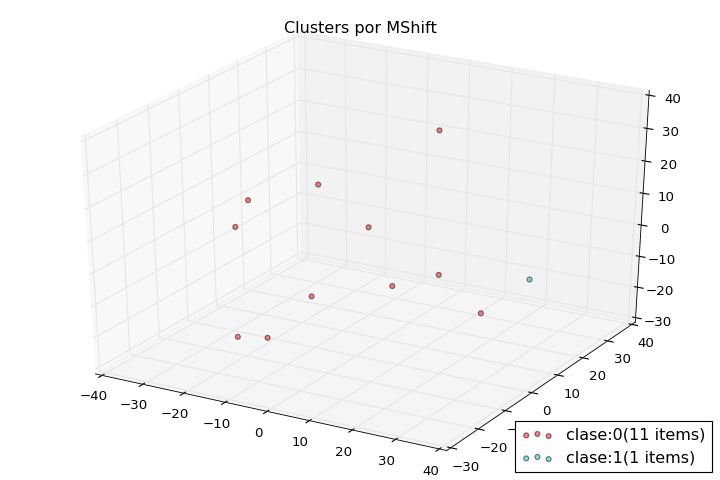

<IPython.core.display.Javascript object>


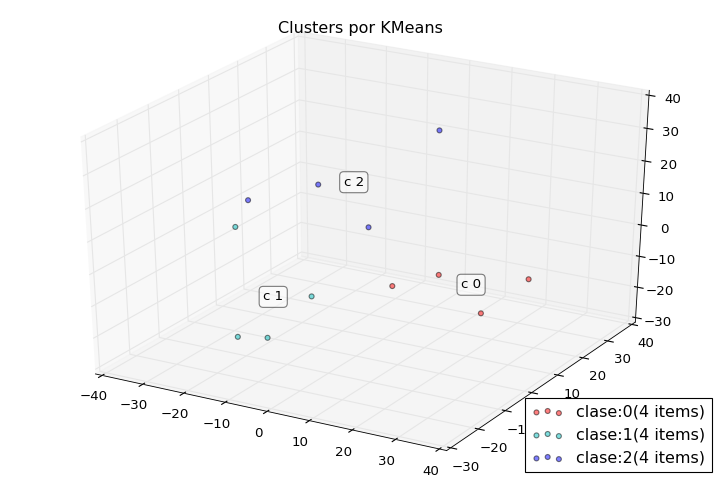

In [5]:
pca = RandomizedPCA(n_components=3, random_state=10)
datos = pca.fit_transform(pca_totales)
d_plots = pd.DataFrame(datos)

b_width = estimate_bandwidth(datos, quantile=0.5, n_samples=datos.shape[0])
ms_ = MeanShift(bandwidth=b_width, bin_seeding=True)
ms_cls = ms_.fit_predict(datos)
d_plots["clase"] = ms_cls
ms_score = silhouette_score(datos, ms_cls)
plot_cls("MShift", d_plots, ms_cls, centers=ms_.cluster_centers_)

km_ = KMeans(n_clusters=3, random_state=10)
km_.fit(datos)
km_cls = km_.predict(datos)
km_score = silhouette_score(datos, km_cls)
d_plots["clase"] = km_cls
plot_cls("KMeans", d_plots, km_cls, centers=km_.cluster_centers_)

# col = [colores[x] for x in km_cls]
# d_plots.plot.scatter(x=0, y=1, c=col, s=20)
# plt.show()

In [6]:
print("MShift:\n\tClusters: {} \n\tS_Score: {}".format(len(np.unique(ms_.labels_)), ms_score))
print("KMeans:\n\tClusters: {} \n\tS_Score: {}".format(len(np.unique(km_.labels_)), km_score))
d_plots.index = new_index
# d_plots["MS-Clustering"] = ms_cls
# d_plots["KM-Clustering"] = km_cls
d_plots[:3]

MShift:
	Clusters: 2 
	S_Score: 0.8776141495043042
KMeans:
	Clusters: 3 
	S_Score: 0.76588303954973


,0,1,2,clase
Bolsa 1-1,-18.093038,1.135780,0.096251,1
Bolsa 1-2,-7.922379,-0.262615,0.061687,1
Bolsa 1-3,-10.919143,-0.186674,0.034338,1


In [7]:
bolsas = [[] for _ in range(12)]
for i, j in itertools.product(range(12), range(10)):
    ind = "Bolsa {0}-{1}".format(i+1, j+1)
    if ind not in d_plots.index:
        continue
    valor = d_plots.loc[ind]["clase"]
    bolsas[i].append(valor)
print(pd.DataFrame(bolsas).shape)

resultados_por_bolsa = pd.DataFrame(columns=["Clase"])
nombre_bolsas = []
for i, b in enumerate(bolsas):
    nombre_bolsas.append("Bolsa %d"%i)
    resultados_por_bolsa.loc[i] = [mode(b)[0][0]]
resultados_por_bolsa.index = nombre_bolsas
resultados_por_bolsa.to_csv("Resultados_x_bolsa.csv", sep="\t")
resultados_por_bolsa

(12, 10)


,Clase
Bolsa 0,1.0
Bolsa 1,1.0
Bolsa 2,1.0
Bolsa 3,1.0
Bolsa 4,1.0
Bolsa 5,1.0
Bolsa 6,2.0
Bolsa 7,1.0
Bolsa 8,1.0
Bolsa 9,1.0


Silohuete Score: 0.877614


<IPython.core.display.Javascript object>


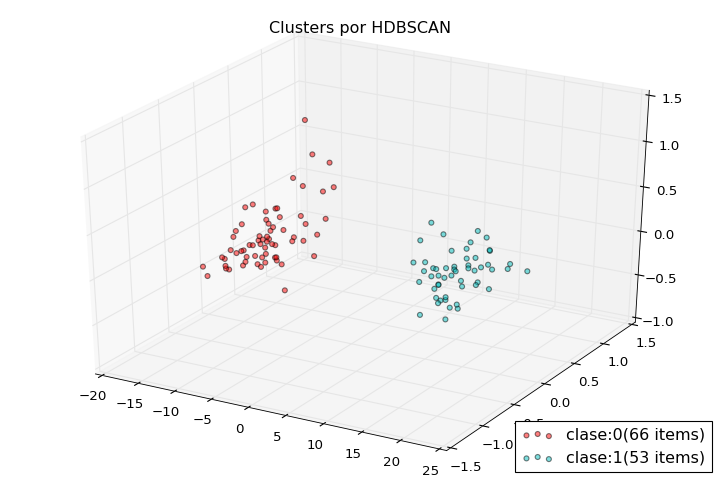

In [8]:
hdb_cls = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=4)
labels = hdb_cls.fit_predict(datos)
hdb_ss = silhouette_score(datos, labels)
print("Silohuete Score: %f"%hdb_ss)
hdb_ssv = silhouette_samples(datos, labels)
datos_2 = pd.DataFrame(datos).copy()
datos_2["clase"] = labels
plot_cls("HDBSCAN", datos_2, labels)

In [5]:
pca_bolsas_unidas = pd.DataFrame()
pca_bolsas = []
files = os.listdir("SojaData/")

for i in range(15):
    pca_temp = np.array([])
    for j in range(12):

        n_file = "Prueba Claudio Bolsa {0}-{1}.csv".format(i, j)
        if n_file not in files:
            continue
        df = pd.read_csv("SojaData/{0}".format(n_file), header=2, index_col=0, skip_blank_lines=True, dtype=np.float64)
        pca_file = RandomizedPCA(n_components=3, random_state=10).fit_transform(df)
        pca_file = np.array(pca_file)
        
        n_cols = pca_file.shape[0] * pca_file.shape[1]
        pca_file = pca_file.reshape(1, n_cols)
        pca_temp = np.append(pca_temp, pca_file)
        pca_bolsas = np.append(pca_bolsas,pca_file)
    pca_bolsas_unidas = pca_bolsas_unidas.append(pd.DataFrame(pca_temp).T, ignore_index=True)

pca_bolsas_unidas.dropna(axis=0, how="all", inplace=True)
pca_bolsas_unidas.fillna(value=0,axis=0, inplace=True)
pca_bolsas_unidas.shape

(12, 15030)

<IPython.core.display.Javascript object>


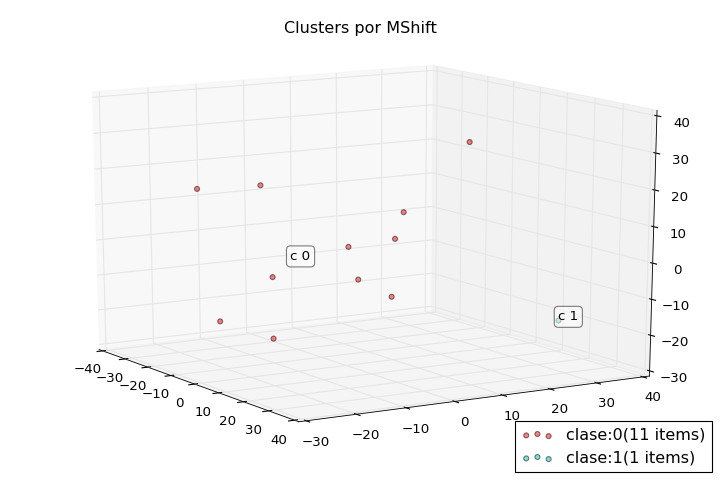

<IPython.core.display.Javascript object>


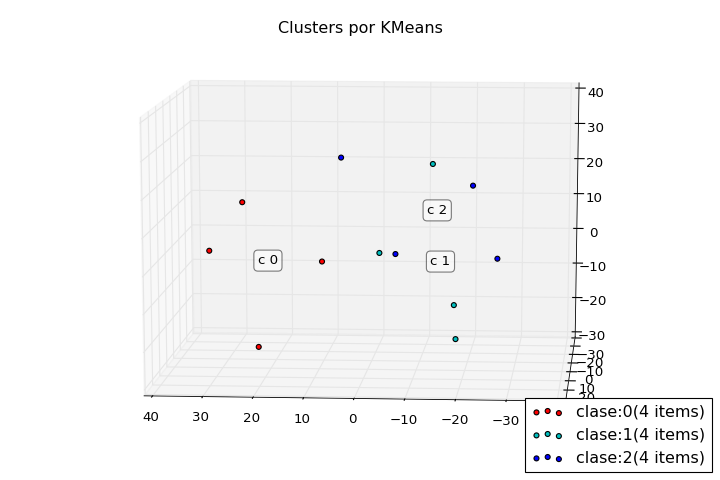

In [8]:
pca_gen = RandomizedPCA(n_components=3, random_state=10)
datos_bolsas = pca_gen.fit_transform(pca_bolsas_unidas)
d_plot_bolsas = pd.DataFrame(datos_bolsas)

b_width = estimate_bandwidth(datos_bolsas, quantile=0.4, n_samples=datos_bolsas.shape[0])
msb_ = MeanShift(bandwidth=b_width, bin_seeding=True)
msb_cls = msb_.fit_predict(datos_bolsas)
d_plot_bolsas["clase"] = msb_cls
msb_score = silhouette_score(datos_bolsas, msb_cls)
plot_cls("MShift", d_plot_bolsas, msb_cls, centers=msb_.cluster_centers_)

kmb_ = KMeans(n_clusters=3, random_state=10)
kmb_.fit(datos_bolsas)
kmb_cls = kmb_.predict(datos_bolsas)
kmb_score = silhouette_score(datos_bolsas, kmb_cls)
d_plot_bolsas["clase"] = kmb_cls
plot_cls("KMeans", d_plot_bolsas, kmb_cls, alpha=1, centers=kmb_.cluster_centers_)

In [16]:
d_plot_bolsas.index = ["Bolsa {}".format(x+1) for x in range(12)]
d_plot_bolsas

,0,1,2,clase
Bolsa 1,28.711696,-14.682085,9.715896,0
Bolsa 2,35.148067,-9.428499,-3.055421,0
Bolsa 3,-0.345759,-15.081849,-4.349848,1
Bolsa 4,10.672877,-3.114941,-4.493506,0
Bolsa 5,-16.019910,-18.234721,-19.662580,1
Bolsa 6,-20.513313,-7.243540,16.218605,2
Bolsa 7,-27.328756,27.138921,2.883922,2
Bolsa 8,-5.969395,13.614938,1.150695,2
Bolsa 9,19.603615,34.662374,-19.681941,0
Bolsa 10,-17.108888,-6.534285,-26.677851,1
